In [ ]:
import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
api_key = '1688d4c2ff8442d9906cb0637a7d7fbc'
symbol = 'BTC/USD'
interval = '5min'
order = 'asc'
start_date = '2021-10-03 00:00:00'
end_date = '2021-10-20 00:00:00'

api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={start_date}&end_date={end_date}&interval={interval}&order={order}&apikey={api_key}'

In [ ]:
data = requests.get(api_url).json()
data_final = pd.DataFrame(data['values'])
data_final

,datetime,open,high,low,close
0,2021-10-03 00:00:00,47657.69141,47812.28125,47651.53125,47812.28125
1,2021-10-03 00:05:00,47814.57031,47832.17188,47721.78125,47744.39062
2,2021-10-03 00:10:00,47736.80859,47757.73828,47697.87891,47727.98828
3,2021-10-03 00:15:00,47729.85156,47790.03125,47671.51953,47692.07812
4,2021-10-03 00:20:00,47696.42188,47800.28906,47696.42188,47745.17188
...,...,...,...,...,...
4880,2021-10-19 23:40:00,64426.26953,64465.21875,64366.05859,64453.55859
4881,2021-10-19 23:45:00,64470.12891,64487.30859,64330.00000,64416.01172
4882,2021-10-19 23:50:00,64437.71875,64437.71875,64230.64062,64243.85156
4883,2021-10-19 23:55:00,64258.87891,64309.30859,64209.41016,64302.23047


In [ ]:
df= data_final.drop(['datetime'],axis=1)
df.head()

,open,high,low,close
0,47657.69141,47812.28125,47651.53125,47812.28125
1,47814.57031,47832.17188,47721.78125,47744.39062
2,47736.80859,47757.73828,47697.87891,47727.98828
3,47729.85156,47790.03125,47671.51953,47692.07812
4,47696.42188,47800.28906,47696.42188,47745.17188


In [ ]:
ma50=df.close.rolling(50).mean()
ma200=df.close.rolling(200).mean()
#ma100

In [ ]:
b_p = pd.to_numeric(df['close'], errors = 'coerce').values
dma50_p = pd.to_numeric(ma50, errors = 'coerce').values
dma200_p = pd.to_numeric(ma200, errors = 'coerce').values

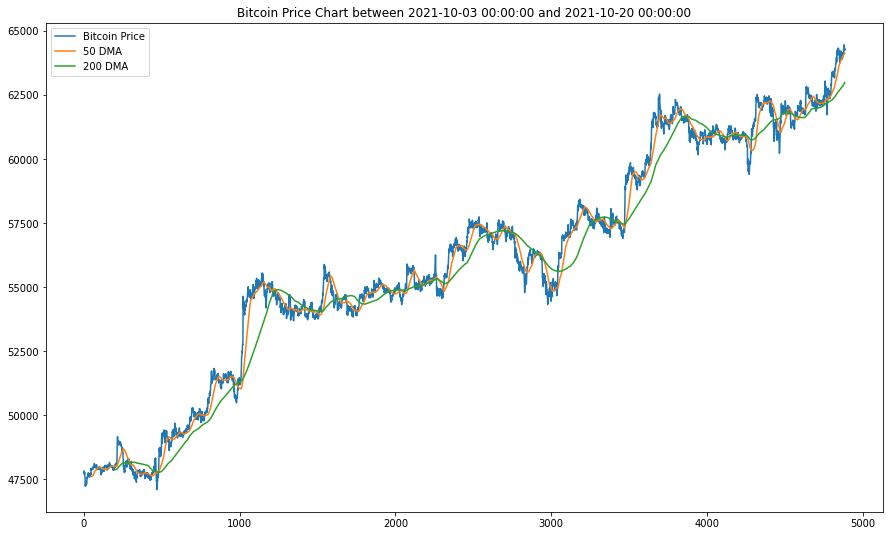

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(b_p, label='Bitcoin Price')
plt.plot(dma50_p, label='50 DMA')
plt.plot(dma200_p, label='200 DMA')
plt.title('Bitcoin Price Chart between '+start_date+' and '+end_date)
plt.legend()
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_final['close'].values.reshape(-1,1))

In [ ]:
time_intervals_to_train = 24
prediction_interval = 12

x_train = []
y_train = []

In [ ]:
for i in range(time_intervals_to_train, len(scaled_data) - prediction_interval):
  x_train.append(scaled_data[i - time_intervals_to_train: i, 0])
  y_train.append(scaled_data[i + prediction_interval, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
x_train.shape

(4849, 24, 1)

In [ ]:
model = Sequential()

model.add(LSTM(128, return_sequences= True, input_shape = (x_train.shape[1], 1), activation = 'relu'))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences= True, activation = 'relu'))
model.add(Dropout(0.3))
model.add(LSTM(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 24, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 24, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer= 'adam', metrics= ['accuracy'])

      there are other type of losses like catagorical cross entropy, binary cross entropy, used for classification purpose
      for **time series analysis** we are using mean squared error for loss

In [ ]:
model.fit(x_train, y_train, epochs=10, batch_size= 64)

Epoch 1/10
76/76 [==============================] - 11s 89ms/step - loss: 0.0258 - accuracy: 2.0623e-04
Epoch 2/10
76/76 [==============================] - 7s 89ms/step - loss: 0.0021 - accuracy: 4.1246e-04
Epoch 3/10
76/76 [==============================] - 7s 90ms/step - loss: 0.0017 - accuracy: 4.1246e-04
Epoch 4/10
76/76 [==============================] - 7s 89ms/step - loss: 0.0018 - accuracy: 4.1246e-04
Epoch 5/10
76/76 [==============================] - 7s 89ms/step - loss: 0.0016 - accuracy: 4.1246e-04
Epoch 6/10
76/76 [==============================] - 7s 90ms/step - loss: 0.0016 - accuracy: 4.1246e-04
Epoch 7/10
76/76 [==============================] - 7s 89ms/step - loss: 0.0016 - accuracy: 4.1246e-04
Epoch 8/10
76/76 [==============================] - 7s 90ms/step - loss: 0.0015 - accuracy: 4.1246e-04
Epoch 9/10
76/76 [==============================] - 7s 88ms/step - loss: 0.0015 - accuracy: 4.1246e-04
Epoch 10/10
76/76 [==============================] - 7s 93ms/step - loss

In [ ]:
#for saving the trained model to be used further in streamlit

# model.save('bitcoin_deep_learning.h5')

In [ ]:
test_start = '2021-10-20 00:00:00'
test_end = '2021-10-23 00:00:00'

test_api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={test_start}&end_date={test_end}&interval={interval}&order={order}&apikey={api_key}'
test_data = requests.get(test_api_url).json()
test_data_final = pd.DataFrame(test_data['values'])
test_data_final

,datetime,open,high,low,close
0,2021-10-20 00:00:00,64300.01172,64381.44922,64235.94141,64257.17188
1,2021-10-20 00:05:00,64255.21875,64265.83984,64099.76953,64134.44922
2,2021-10-20 00:10:00,64133.71875,64207.78125,64133.71875,64177.23047
3,2021-10-20 00:15:00,64185.44922,64232.28906,64119.21875,64137.94141
4,2021-10-20 00:20:00,64137.69922,64166.08984,64083.42188,64083.42188
...,...,...,...,...,...
850,2021-10-22 23:40:00,60831.53906,60843.91016,60750.00000,60754.03906
851,2021-10-22 23:45:00,60754.98828,60796.92188,60720.00000,60720.50000
852,2021-10-22 23:50:00,60720.01172,60729.32031,60690.42969,60710.87891
853,2021-10-22 23:55:00,60717.87891,60720.78906,60680.14062,60696.71875


In [ ]:
bitcoin_prices = pd.to_numeric(test_data_final['close'], errors = 'coerce').values
# bitcoin_prices

In [ ]:
test_inputs = test_data_final['close'].values
test_inputs = test_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(test_inputs)

In [ ]:
x_test = []

for x in range(time_intervals_to_train, len(model_inputs)):
  x_test.append(model_inputs[x - time_intervals_to_train:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

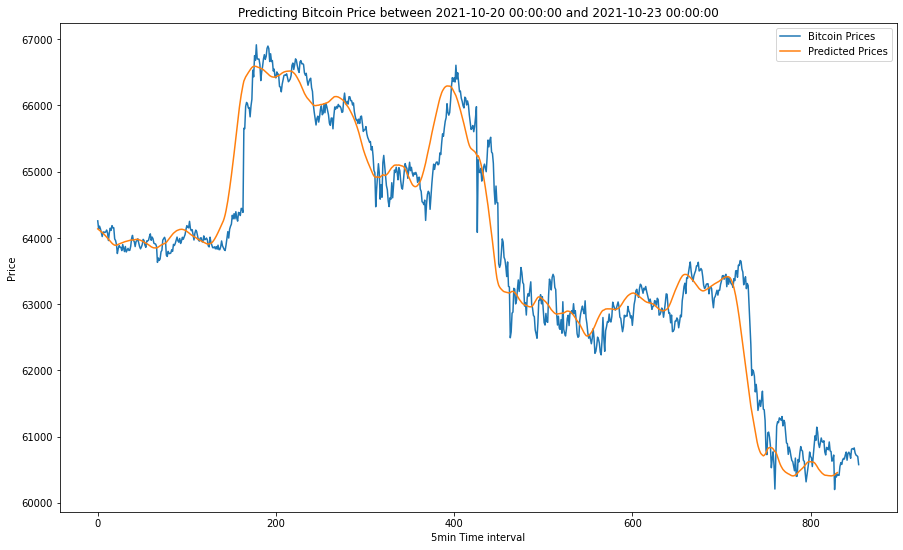

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(bitcoin_prices, label = 'Bitcoin Prices')
plt.plot(prediction_prices, label = 'Predicted Prices')
plt.title('Predicting Bitcoin Price between '+test_start+' and '+test_end)
plt.xlabel('5min Time interval')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
last_data = model_inputs[len(model_inputs) - time_intervals_to_train : len(model_inputs), 0]
last_data = np.array(last_data)

In [ ]:
last_data.shape

(24,)

In [ ]:
last_data = np.reshape(last_data, (1, last_data.shape[0], 1))

In [ ]:
prediction = model.predict(last_data)

In [ ]:
prediction = scaler.inverse_transform(prediction)

In [ ]:
prediction

array([[60464.418]], dtype=float32)

In [ ]:
print(prediction[0])

[60464.418]
